In [6]:
# ==========================
# Autoencoder – MNIST Reconstruction
# ==========================
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml


# --- Load and subsample data ---
mnist = fetch_openml("mnist_784", as_frame=False)
X, y = mnist.data, mnist.target.astype(int)
random_state = 42

size = 50000  # smaller for CPU compute
idx = np.random.choice(len(X), size=size, replace=False)
X_sub, y_sub = X[idx], y[idx]

# --- Scale ---
X_scaled = StandardScaler().fit_transform(X_sub)

In [7]:
# --- Nonlinear AE with Linear Bottleneck ---
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim=2, hidden_dims=(128, 64)):
        super().__init__()
        # Encoder: ReLU activations, last layer linear
        enc = []
        prev = input_dim
        for h in hidden_dims:
            enc += [nn.Linear(prev, h), nn.ReLU()]
            prev = h
        enc += [nn.Linear(prev, latent_dim)]  # linear bottleneck
        self.encoder = nn.Sequential(*enc)

        # Decoder: mirror, last layer linear
        dec = []
        prev = latent_dim
        for h in reversed(hidden_dims):
            dec += [nn.Linear(prev, h), nn.ReLU()]
            prev = h
        dec += [nn.Linear(prev, input_dim)]
        self.decoder = nn.Sequential(*dec)

        # Xavier init
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        z = self.encoder(x)
        xhat = self.decoder(z)
        return xhat

In [8]:
# --- Training loop ---
def train_autoencoder(X, ae, lr=1e-3, n_epochs=150, batch_size=256, device="cpu"):
    X = torch.tensor(X, dtype=torch.float32).to(device)
    loader = DataLoader(TensorDataset(X), batch_size=batch_size, shuffle=True)
    opt = torch.optim.Adam(ae.parameters(), lr=lr, weight_decay=1e-5)
    loss_fn = nn.MSELoss()

    ae.to(device)
    ae.train()
    losses = []
    for epoch in tqdm(range(n_epochs)):
        total = 0
        for (xb,) in loader:
            xb = xb.to(device)
            xhat = ae(xb)
            loss = loss_fn(xhat, xb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total += loss.item()
        losses.append(total / len(loader))
    return losses

100%|██████████| 200/200 [01:22<00:00,  2.42it/s]


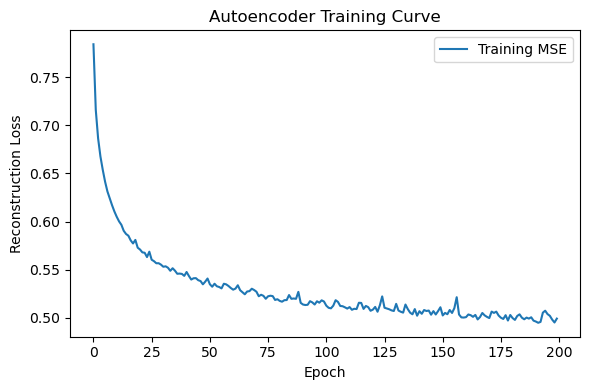

In [9]:
# --- Run ---
input_dim = X_scaled.shape[1]
latent_dim = 2
ae = AutoEncoder(input_dim, latent_dim)
losses = train_autoencoder(X_scaled, ae, n_epochs=200)

# --- Plot Reconstruction Error ---
plt.figure(figsize=(6,4))
plt.plot(losses, label="Training MSE")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")
plt.title("Autoencoder Training Curve")
plt.legend()
plt.tight_layout()
plt.savefig("docs/autoencoder_training_curve.png", dpi=150)
plt.show()

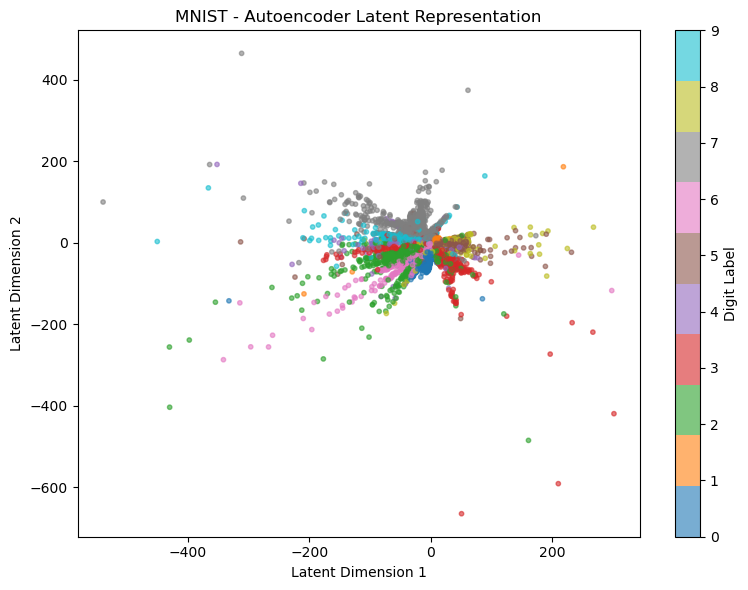

In [11]:
# --- Latent Embedding Visualization ---
ae.eval()
with torch.no_grad():
    Z = ae.encoder(torch.tensor(X_scaled, dtype=torch.float32)).numpy()

plt.figure(figsize=(8,6))
sc = plt.scatter(Z[:,0], Z[:,1], c=y_sub, cmap="tab10", s=10, alpha=0.6)
plt.colorbar(sc, label="Digit Label")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("MNIST - Autoencoder Latent Representation")
plt.tight_layout()
plt.savefig("docs/autoencoder_latent_2d.png", dpi=150)
plt.show()